In [1]:
from src.common import *
from src.houses import *
from src.agents import *
from src.bidding import *
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots
np.set_printoptions(suppress=True) # stops scientific numbers

In [2]:
n = 10_000
agents = generate_agents(n)
size = sys.getsizeof(agents)
print(f"The agents array takes up {size} bytes of memory, which is {size/(1024**3):.6f} GB of memory")
print(agents)

The agents array takes up 310112 bytes of memory, which is 0.000289 GB of memory
[(   0, 154644.57276764, 0, 23, False, -1, 0., 0.6360557 )
 (   1, 492559.95766221, 6, 73, False, -1, 0., 0.77041364)
 (   2, 226161.67378527, 2, 88, False, -1, 0., 0.7734569 ) ...
 (9997, 602825.37260594, 7, 98, False, -1, 0., 0.7182622 )
 (9998, 323849.92496958, 4,  7, False, -1, 0., 0.7907562 )
 (9999, 177052.31256772, 0, 14, False, -1, 0., 0.696887  )]


In [3]:
freq, total = get_freq_and_total(agents)
proportions = get_proportion(freq, total)
agents = check_happiness(agents, proportions)

In [4]:
houses = initialize_houses(agents)
print(houses)

[(   0, -1, 62, 100000.) (   1, -1, 63, 100000.) (   2, -1, 77, 100000.)
 ... (9997, -1,  3, 100000.) (9998, -1, 80, 100000.)
 (9999, -1, 52, 100000.)]


In [5]:
current_rents = get_current_rents(houses)
utility = get_utilities(agents, proportions, current_rents)
print(utility)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.8556345  0.7236272  0.7842099  ... 0.88706267 0.7973114  0.9487589 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.81737244 0.6995868  0.8772575  ... 0.9593628  0.7356382  0.99707854]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
bids, neighborhoods_chosen = place_bid(agents, utility)
print(bids)

[     0.         246279.97295933      0.         ... 301412.68630297
      0.              0.        ]


In [7]:
agent_house_mapping(agents, houses)
priced_out_mask = check_priced_out(agents, houses, proportions)
evict_priced_out(agents, houses, priced_out_mask)

In [8]:
agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
print(f"Iteration 0: {round(np.mean(agents["happy"])*100,3)}% of agents are happy")
print(f"{round(np.sum(agents["neighborhood"]==-1)*100/n,3)}% of agents are homeless")
print()
# happiness check -> bids -> price update -> assignment -> happiness check
max_iter = 250
count = 1
convergence_count = 0
prev_happy, prev_homeless = 0,0
while not np.all(agents["happy"]):
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)
    current_rents = get_current_rents(houses)

    utilities = get_utilities(agents, proportions, current_rents)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    happy_agents = round(np.mean(agents["happy"])*100,3)
    homeless_agents = round(np.sum(agents["neighborhood"]==-1)*100/n,3)
    print(f"Iteration {count}: {happy_agents}% of agents are happy")
    print(f"{homeless_agents}% of agents are homeless")
    print()
    count += 1
    if count >= max_iter:
        break
    """if happy_agents == prev_happy and homeless_agents == prev_homeless:
        convergence_count += 1
        if convergence_count >= 2:
            break # we have converged if both criteria stay the same
    else:
        prev_happy = happy_agents
        prev_homeless = homeless_agents
    if count >= max_iter:
        break"""

# runtime:
# 1 mil agents, not plugged in: 3m 20.9s
# 1 mil agents, plugged in: 2m 40.6s
# 30 mil agents (approx delhi popln): failed to run - out of memory

Iteration 0: 56.6% of agents are happy
95.97% of agents are homeless

Iteration 1: 4.03% of agents are happy
95.97% of agents are homeless

Iteration 2: 27.14% of agents are happy
60.17% of agents are homeless

Iteration 3: 28.54% of agents are happy
59.2% of agents are homeless

Iteration 4: 27.95% of agents are happy
59.21% of agents are homeless

Iteration 5: 27.95% of agents are happy
59.21% of agents are homeless

Iteration 6: 27.95% of agents are happy
59.21% of agents are homeless

Iteration 7: 27.96% of agents are happy
59.2% of agents are homeless

Iteration 8: 27.97% of agents are happy
59.1% of agents are homeless

Iteration 9: 28.29% of agents are happy
58.89% of agents are homeless

Iteration 10: 28.1% of agents are happy
58.97% of agents are homeless

Iteration 11: 28.21% of agents are happy
58.9% of agents are homeless

Iteration 12: 28.12% of agents are happy
58.94% of agents are homeless

Iteration 13: 28.22% of agents are happy
58.87% of agents are homeless

Iteration

In [9]:
for i in range(-1, np.max(agents["neighborhood"]+1)):
    print(f"Neighborhood {i}: {np.sum(agents["neighborhood"]==i)} agents")

Neighborhood -1: 5894 agents
Neighborhood 0: 32 agents
Neighborhood 1: 39 agents
Neighborhood 2: 36 agents
Neighborhood 3: 34 agents
Neighborhood 4: 35 agents
Neighborhood 5: 43 agents
Neighborhood 6: 37 agents
Neighborhood 7: 38 agents
Neighborhood 8: 35 agents
Neighborhood 9: 47 agents
Neighborhood 10: 34 agents
Neighborhood 11: 32 agents
Neighborhood 12: 32 agents
Neighborhood 13: 30 agents
Neighborhood 14: 41 agents
Neighborhood 15: 44 agents
Neighborhood 16: 39 agents
Neighborhood 17: 38 agents
Neighborhood 18: 73 agents
Neighborhood 19: 28 agents
Neighborhood 20: 42 agents
Neighborhood 21: 30 agents
Neighborhood 22: 39 agents
Neighborhood 23: 36 agents
Neighborhood 24: 37 agents
Neighborhood 25: 31 agents
Neighborhood 26: 40 agents
Neighborhood 27: 36 agents
Neighborhood 28: 32 agents
Neighborhood 29: 34 agents
Neighborhood 30: 29 agents
Neighborhood 31: 37 agents
Neighborhood 32: 37 agents
Neighborhood 33: 30 agents
Neighborhood 34: 32 agents
Neighborhood 35: 104 agents
Neighbor

In [10]:
no_house = np.sum(agents["house"]==-1)
no_tenant = np.sum(houses["tenant"]==-1)
homeless = np.sum(agents["neighborhood"]==-1)
happy = np.sum(agents["happy"])
print(f"Agents with no house: {no_house}")
print(f"Houses with no tenants: {no_tenant}")
print(f"Homeless agents (neighborhood = -1): {homeless}")
print(f"Happy agents: {happy}")

Agents with no house: 5894
Houses with no tenants: 5836
Homeless agents (neighborhood = -1): 5894
Happy agents: 2851


In [11]:
"""def run_sim(n, max_iter=100):
    # initialize agents and houses fresh each run
    agents = generate_agents(n)
    houses = initialize_houses(agents)
    
    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)

    priced_out_mask = check_priced_out(agents, houses, proportions)
    evict_priced_out(agents, houses, priced_out_mask)
    current_rents = get_current_rents(houses)

    utilities = get_utilities(agents, proportions,current_rents)
    bids, neighborhoods_chosen = place_bid(agents, utilities)
    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)

    freq, total = get_freq_and_total(agents)
    proportions = get_proportion(freq, total)
    agents = check_happiness(agents, proportions)

    count = 1
    while not np.all(agents["happy"]):
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)

        priced_out_mask = check_priced_out(agents, houses, proportions)
        evict_priced_out(agents, houses, priced_out_mask)
        current_rents = get_current_rents(houses)

        utilities = get_utilities(agents, proportions, current_rents)
        bids, neighborhoods_chosen = place_bid(agents, utilities)
        agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)
        houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)
        
        freq, total = get_freq_and_total(agents)
        proportions = get_proportion(freq, total)
        agents = check_happiness(agents, proportions)

        count += 1
        if count >= max_iter:
            break
    
    # collect final stats
    happiness = np.mean(agents["happy"]) * 100
    homelessness = np.sum(agents["neighborhood"] == -1) * 100 / n
    return happiness, homelessness

# Monte Carlo loop
n = 10_000
runs = 30
results = [run_sim(n) for _ in range(runs)]

happiness_vals, homelessness_vals = zip(*results)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(happiness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Happiness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Happiness (30 runs)")

plt.subplot(1,2,2)
plt.hist(homelessness_vals, bins=10, edgecolor="black")
plt.xlabel("Final Homelessness (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Homelessness (30 runs)")

plt.tight_layout()
plt.show()"""

# first run: 76m 18.7s = 4578.7s
# after skipping utility check for happy agents: 71m 16.6s = 4276.6s (~6.6% speedup)

'def run_sim(n, max_iter=100):\n    # initialize agents and houses fresh each run\n    agents = generate_agents(n)\n    houses = initialize_houses(agents)\n\n    freq, total = get_freq_and_total(agents)\n    proportions = get_proportion(freq, total)\n\n    priced_out_mask = check_priced_out(agents, houses, proportions)\n    evict_priced_out(agents, houses, priced_out_mask)\n    current_rents = get_current_rents(houses)\n\n    utilities = get_utilities(agents, proportions,current_rents)\n    bids, neighborhoods_chosen = place_bid(agents, utilities)\n    agents, houses, cutoff_bids = allocate_houses(agents, houses, bids, neighborhoods_chosen)\n    houses = update_prices(houses, neighborhoods_chosen, cutoff_bids)\n\n    freq, total = get_freq_and_total(agents)\n    proportions = get_proportion(freq, total)\n    agents = check_happiness(agents, proportions)\n\n    count = 1\n    while not np.all(agents["happy"]):\n        freq, total = get_freq_and_total(agents)\n        proportions = get_

In [12]:
no_house = np.sum(agents["house"]==-1)
no_tenant = np.sum(houses["tenant"]==-1)
homeless = np.sum(agents["neighborhood"]==-1)
happy = np.sum(agents["happy"])
print(f"Agents with no house: {no_house}")
print(f"Houses with no tenants: {no_tenant}")
print(f"Homeless agents (neighborhood = -1): {homeless}")
print(f"Happy agents: {happy}")

Agents with no house: 5894
Houses with no tenants: 5836
Homeless agents (neighborhood = -1): 5894
Happy agents: 2851


Line of best fit (linear): y = 0.5113x + -70590.3047
correlation coefficient (linear): 0.9899

Line of best fit (log): y = 2.0375x + -15.1774
correlation coefficient (log): 0.2513


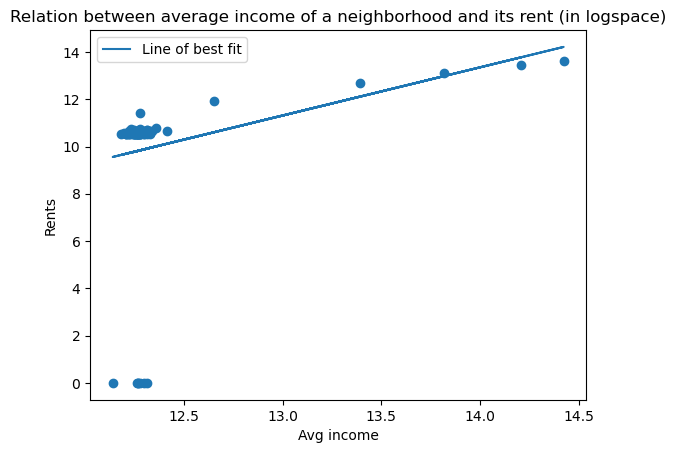

In [13]:
# plot the correlation between avg neighborhood income and the rent there
avg_income = np.zeros(N_NEIGHBORHOODS)
rent = np.zeros(N_NEIGHBORHOODS) # all houses in a neighborhood share the same price, so avg is meaningless

for i in range(N_NEIGHBORHOODS):
    agent_mask = agents["neighborhood"] == i
    if len(agent_mask) > 0:
        avg_income[i] = np.mean(agents["income"][agent_mask])
        if rent[i] == 0:
            valid = agents["rent_paid"][agent_mask]
            rent[i] = valid[0]
    else:
        avg_income[i] = 0
    
log_income = np.log(avg_income)
log_rent = np.zeros_like(log_income)
for i in range(len(rent)):
    if rent[i] > 0:
        log_rent[i] = np.log(rent[i])
    else:
        log_rent[i] = 0

m_linear, b_linear = np.polyfit(avg_income, rent,1)
correlation_linear = np.corrcoef(avg_income, rent)[0,1]
m,b = np.polyfit(log_income, log_rent, 1) # m here -> income elasticity of demand for housing
correlation = np.corrcoef(log_income, log_rent)[0,1]
print(f"Line of best fit (linear): y = {m_linear:.4f}x + {b_linear:.4f}")
print(f"correlation coefficient (linear): {correlation_linear:.4f}")
print()
print(f"Line of best fit (log): y = {m:.4f}x + {b:.4f}")
print(f"correlation coefficient (log): {correlation:.4f}")
plt.scatter(log_income, log_rent)
plt.plot(log_income, m*log_income+b, label = "Line of best fit")
plt.title("Relation between average income of a neighborhood and its rent (in logspace)")
plt.xlabel("Avg income")
plt.ylabel("Rents")
plt.legend()
plt.show()

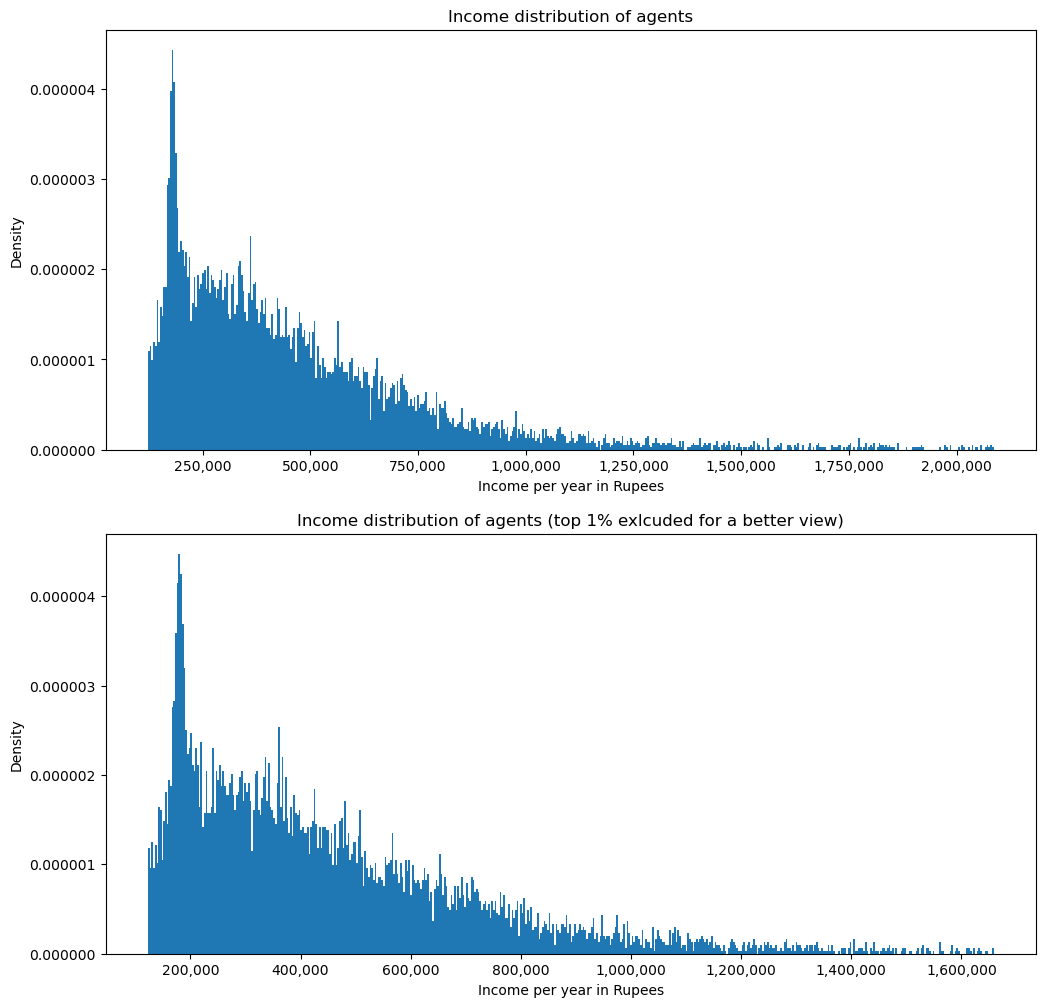

In [14]:
# plot the agents income distribution
incomes = agents["income"]

# Cut off at, say, the 99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))


# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:f}'))

plt.show()